# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
df = pd.read_csv("CowboyCigsData.csv")
df.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [4]:
df.shape[1]

3

Let's check out the data types of our columns.

In [5]:
df.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [6]:
df.isnull().sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [7]:
df.drop(columns=["Unnamed: 0"],inplace=True)

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [8]:
df = df.rename(columns={'Time':'Month'})

# Set 'Month' as the index
df.set_index('Month', inplace=True)

Call a head() to check this has worked. 

In [9]:
df.head()

,#CigSales
Month,
1949-01,1000112
1949-02,1000118
1949-03,1000132
1949-04,1000129
1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [10]:
df.index = pd.to_datetime(df.index)

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [11]:
y = df['#CigSales']

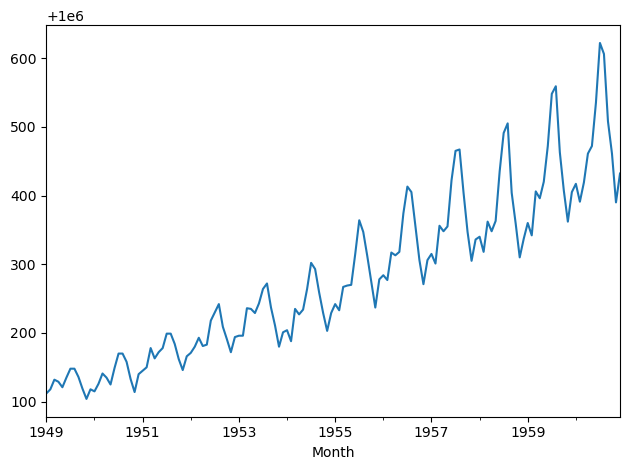

In [12]:
y.plot()
plt.tight_layout()
plt.show()

Check the type of our new variable. 

In [13]:
y.dtype

dtype('int64')

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [14]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

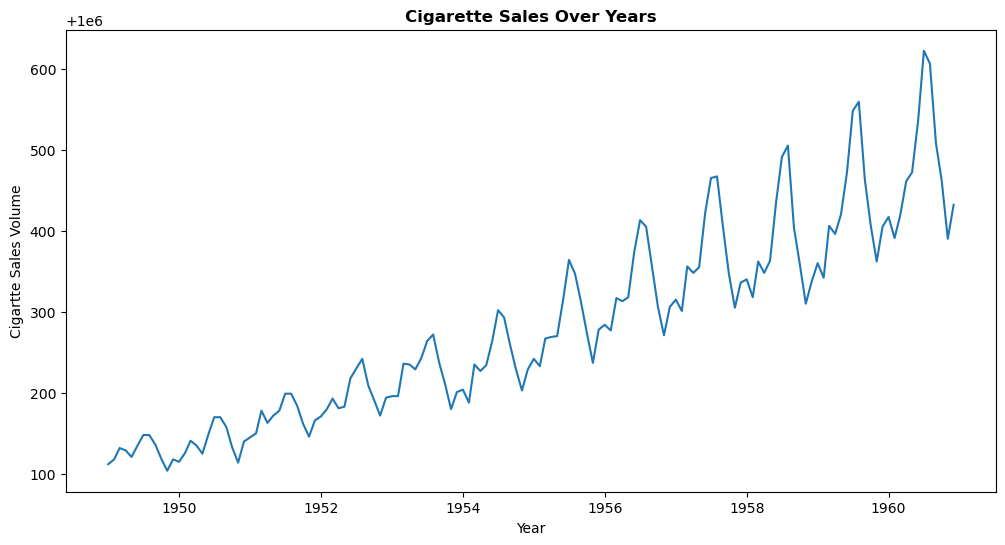

In [15]:
plt.figure(figsize = (12, 6))
plt.plot(df.index, y)
plt.xlabel("Year")
plt.ylabel("Cigartte Sales Volume")
plt.title("Cigarette Sales Over Years", fontweight="bold")

plt.show()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

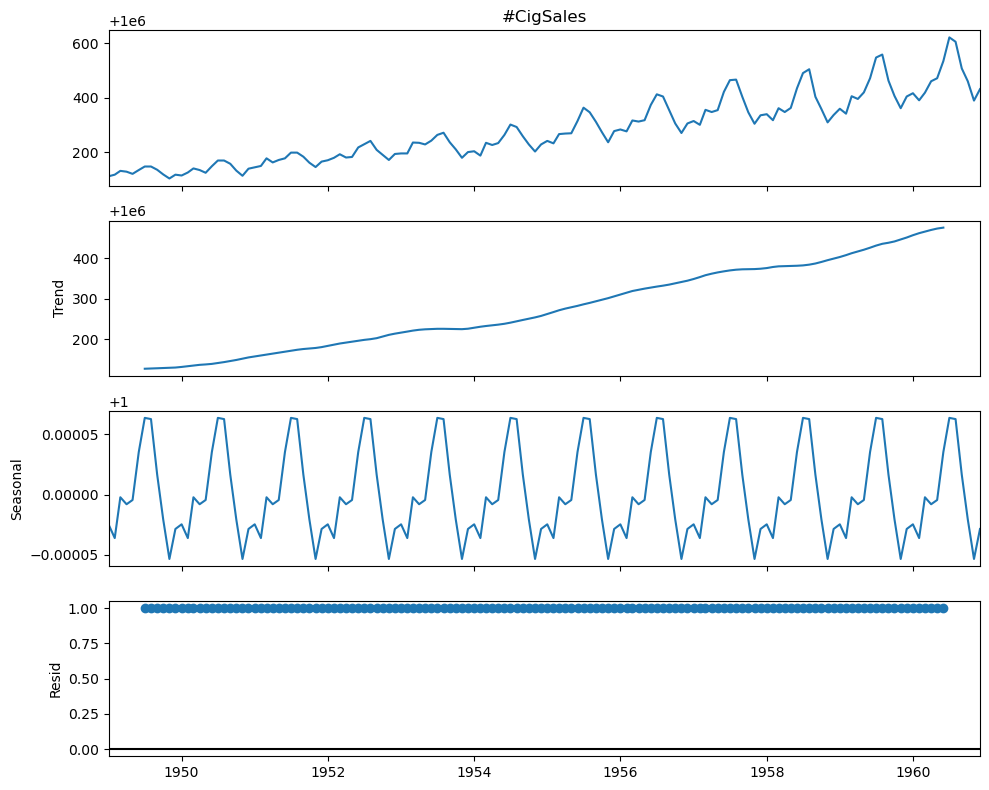

In [16]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = seasonal_decompose(y, model='multiplicative', period=12)
plt.rcParams.update({'figure.figsize': (10, 8)})
decomposition.plot()
plt.tight_layout()
pyplot.show()

# # Import seasonal_decompose 
# from statsmodels.tsa.seasonal import _ _ _

# # Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
# _ _ _ = seasonal_decompose(y)

# # Make three variables for trend, seasonal and residual components respectively. 
# # Assign them the relevant features of decomposition 
# trend = decomposition.trend
# seasonal = _ _ _.seasonal
# _ _ _ = decomposition.resid

# # Plot the original data, the trend, the seasonality, and the residuals 
# plt.subplot(411)
# plt.plot(y, label = '_ _ _')
# plt.legend(loc = 'best')
# plt.subplot(412)
# plt.plot(trend, label = 'Trend')
# plt.legend(loc = 'best')
# plt._ _ _(413)
# plt._ _ _(seasonal, label = '_ _ _')
# plt._ _ _(loc = 'best')
# plt._ _ _(414)
# plt._ _ _(residual, label = 'Residuals')
# plt._ _ _(loc = 'best')
# plt._ _ _()

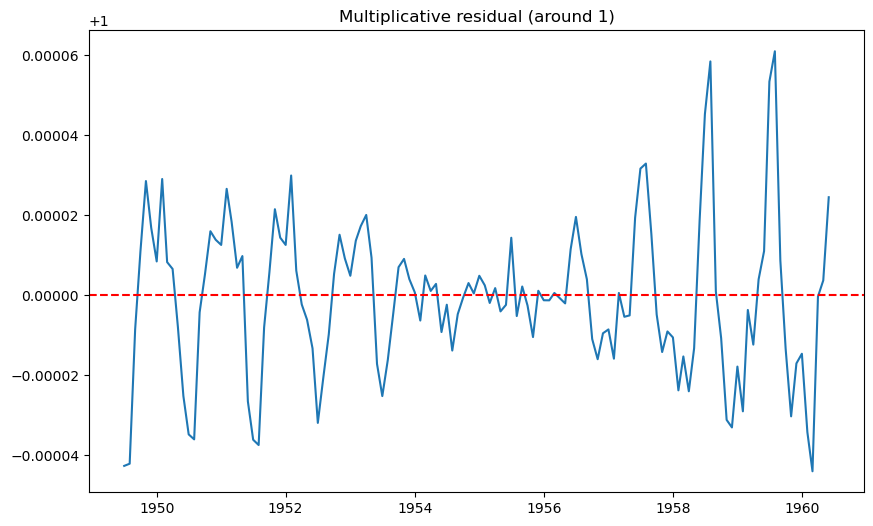

In [17]:
resid = decomposition.resid.dropna()
plt.figure(figsize=(10, 6));
plt.plot(resid);
plt.title("Multiplicative residual (around 1)");
plt.axhline(1, ls='--', color='red');
plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [18]:
from statsmodels.tsa.stattools import kpss
kpss(y)

/var/folders/vl/d4jp3x4n6pvgdsw9fp1v7m6h0000gn/T/ipykernel_2865/4027067367.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(y)


(1.651312235417082,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

**KPSS Test Interpretation**

The KPSS test checks whether a time series is stationary.  

- **Null hypothesis (H₀):** The series is stationary  
- **Alternative hypothesis (H₁):** The series is not stationary  

**Results:**  
- Test statistic: `1.6513`  
- p-value: `0.01`  
- Critical values: {10%: 0.347, 5%: 0.463, 2.5%: 0.574, 1%: 0.739}  

**Interpretation:**  
The test statistic (1.6513) is greater than all critical values, even at the strict 1% level (0.739).  
The p-value (0.01) is less than 0.05, so we reject the null hypothesis and conclude that the series is **not stationary**.  
This indicates that the statistical properties of the series (mean, variance) change over time.  
The series should be transformed (e.g., differencing, detrending, or log transformation) before applying models that require stationarity.

======================================================================

**KPSS 检验结果解释**

KPSS 检验用于判断时间序列是否平稳。  

- **原假设 (H₀)：** 序列是平稳的  
- **备择假设 (H₁)：** 序列不是平稳的  

**结果：**  
- 检验统计量: `1.6513`  
- p 值: `0.01`  
- 临界值: {10%: 0.347, 5%: 0.463, 2.5%: 0.574, 1%: 0.739}  

**解释：**  
检验统计量 (1.6513) 大于所有显著性水平下的临界值，即便在最严格的 1% 水平 (0.739) 也显著超出。  
p 值 (0.01) 小于 0.05，因此拒绝原假设，认为该时间序列是**非平稳的**。  
这说明序列的统计特征（均值、方差）会随时间变化，需要在建模前进行平稳化处理（如差分、去趋势或对数变换）。

## ADF vs KPSS — Stationarity Tests

**ADF (Augmented Dickey-Fuller)**
- **H₀**: The series is **non-stationary** (has a unit root)  
- **H₁**: The series is **stationary** (no unit root)  
- **When to use**: When you want to prove the series is stationary  
- **Typical use case**: Unit root test before ARIMA modeling  
- **Interpretation**: p-value < 0.05 → reject H₀ → conclude the series is stationary  
- **Strengths**: Sensitive to stochastic trends (random walk)  
- **Limitations**: May misjudge trend-stationary series

---

**KPSS (Kwiatkowski–Phillips–Schmidt–Shin)**
- **H₀**: The series is **stationary**  
- **H₁**: The series is **non-stationary**  
- **When to use**: When you want to prove the series is non-stationary  
- **Typical use case**: Check for trend stationarity  
- **Interpretation**: p-value < 0.05 → reject H₀ → conclude the series is non-stationary  
- **Strengths**: Good at detecting trend stationarity  
- **Limitations**: Less sensitive to purely stochastic trends

---

**Why use both?**
- ADF: H₀ = non-stationary  
- KPSS: H₀ = stationary  
- If both agree → strong evidence for the conclusion  
    - ADF p < 0.05 and KPSS p > 0.05 → stationary  
    - ADF p > 0.05 and KPSS p < 0.05 → non-stationary  
- If results conflict → may be borderline case; investigate trend/seasonality further


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

<Axes: title={'center': 'Original Data'}, xlabel='Month'>

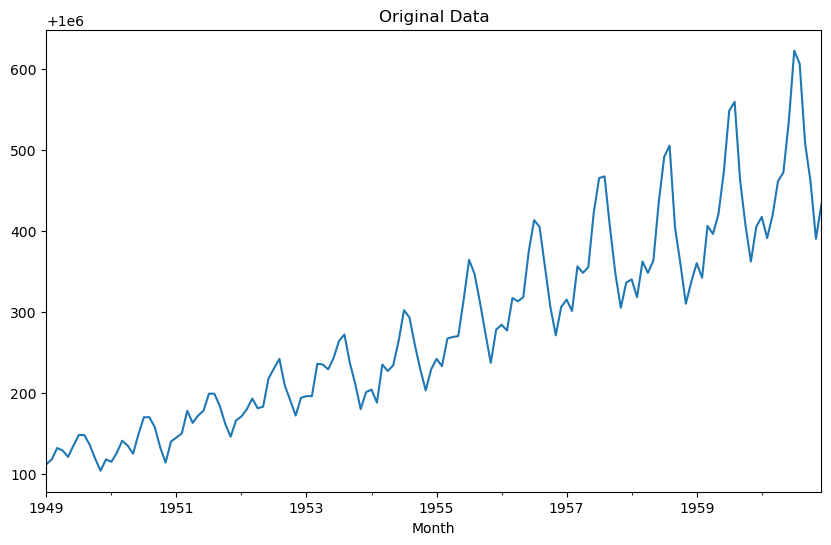

In [19]:
y.plot(figsize=(10, 6), title="Original Data")

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

Applying a log transformation helps `stabilize the variance` in a time series and reduce `heteroscedasticity`.

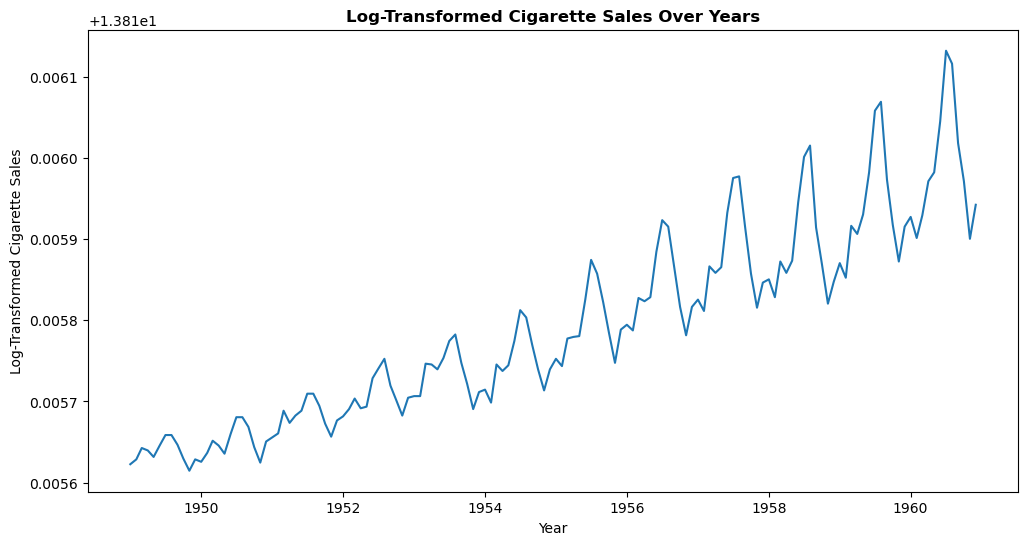

In [20]:
y_log = np.log(y)

plt.figure(figsize=(12, 6))
plt.plot(df.index, y_log)
plt.xlabel("Year")
plt.ylabel("Log-Transformed Cigarette Sales")
plt.title("Log-Transformed Cigarette Sales Over Years", fontweight="bold")

plt.show()


When you plot this, you can see how the variance in our data now remains constant over time.

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

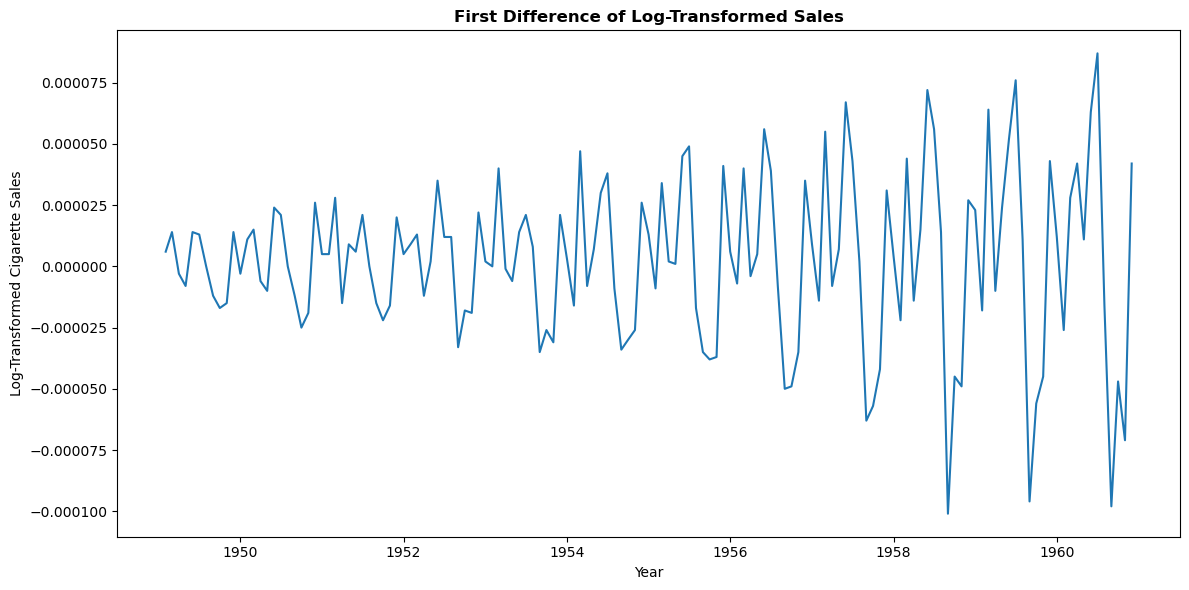

In [21]:
y_diff = y_log.diff().dropna()

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(y_diff.index, y_diff)
plt.xlabel("Year")
plt.ylabel("Log-Transformed Cigarette Sales")
plt.title("First Difference of Log-Transformed Sales", fontweight='bold')
plt.tight_layout()

plt.show()

In [22]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y_diff.dropna())  # 对差分后的序列做ADF检验
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

ADF Statistic: -2.8296
p-value: 0.0542


In [23]:
kpss(y_diff)

/var/folders/vl/d4jp3x4n6pvgdsw9fp1v7m6h0000gn/T/ipykernel_2865/4244846731.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(y_diff)


(0.023897674207570562,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

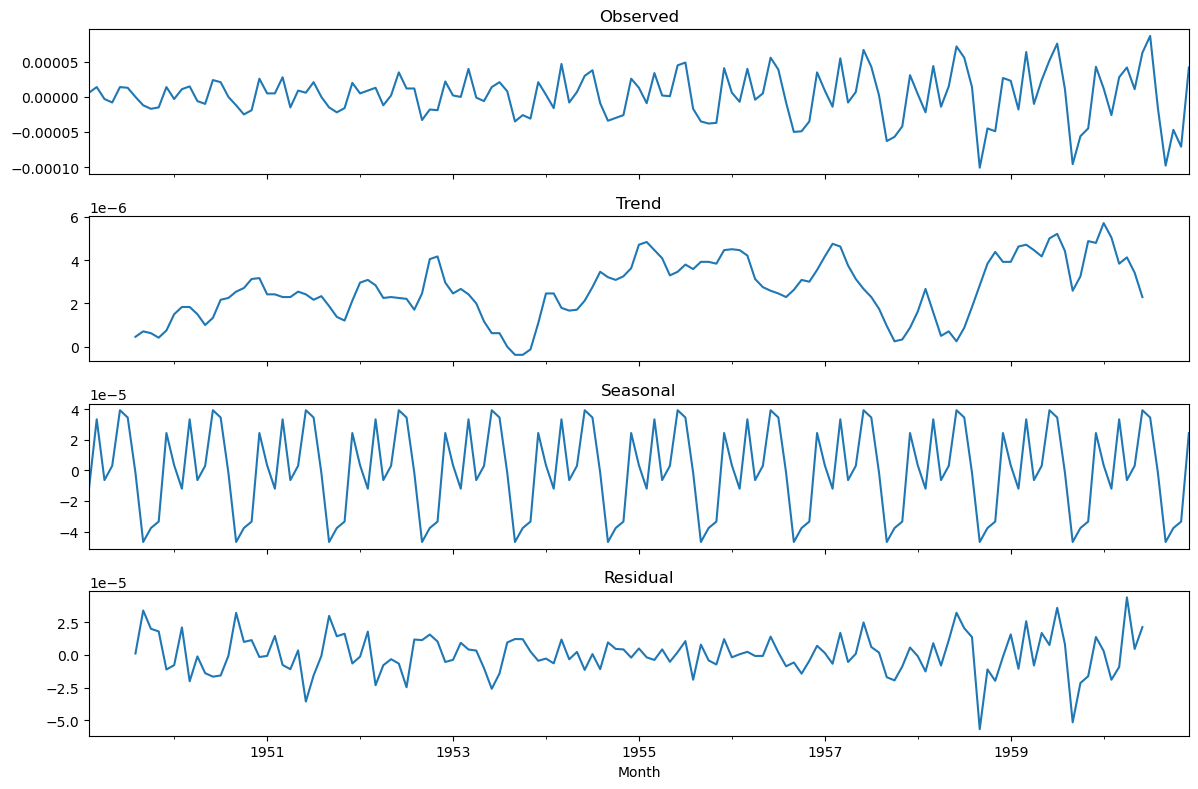

In [24]:
decomp_log = seasonal_decompose(y_diff, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomp_log.observed.plot(ax=axes[0], title='Observed')
decomp_log.trend.plot(ax=axes[1], title='Trend')
decomp_log.seasonal.plot(ax=axes[2], title='Seasonal')
decomp_log.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()
plt.show()

1. 说明选择 additive 是合理的：因为 `trend` 和 `seasonal` 成分的变化幅度是相对固定的（而不是随总体水平的增长而增加），所以可以使用 `additive model` 而非 `multiplicative`。这个proj里面，先用`multiplicative` decompose 原始的数据, 然后用`log`消除趋势，移除`variance`.

2. 残差没有明显模式：`Residual` 图中没有明确的趋势或季节性周期，这说明大部分结构性信息已经被 `trend` 和 `seasonal` 成分解释了 —— 这是你想要的结果，说明你现在的预处理（`log + diff`）很有效。

3. 是否可以建模: 当前数据变换之后已经去除了大部分趋势和季节性 —— 基本满足平稳性条件，可以考虑用 `ARIMA`（特别是 `SARIMA`）来建模预测。

After applying `first-order differencing`, we conducted the ***ADF*** (`Augmented Dickey-Fuller`) test, which returned a `p-value` slightly above 0.05. Although this suggests we cannot strongly reject the null hypothesis of ***non-stationarity***, we further validated stationarity using the ***KPSS*** (`Kwiatkowski–Phillips–Schmidt–Shin`) test. The ***KPSS*** test failed to reject the null hypothesis, as its p-value was greater than 0.05 — indicating that the series can be considered ***stationary***.

To visually verify, we decomposed the differenced time series using an ***additive*** model. The residual plot showed no discernible trend or repeating seasonal pattern, suggesting that the trend and seasonal components have been effectively extracted, and the remaining series is mostly noise.

Given these results, we conclude that the transformed series is stationary, with both trend and seasonality adequately removed. The data is now ready for ***ARIMA*** modeling, particularly ***SARIMA***, since the seasonal structure was initially present and has now been appropriately accounted for.

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

虽然我们之前已经做了log 和 1st differencing，通过了ADF和KPSS检测了stationary。至少初步可以判断出time series在进行了log 和 1st differencing以后，数据会变得stationary。但是问题是如果我们用这个y_diff，预测出来的数据结果可能不对。log transform可以在def function之前做，y_diff = log(y_t) - log(y_{t-1}) = log(y_t / y_{t-1}), 不过没有必要在def function前对time series做differencing。这也解释了为什么我后面用的是y_diff的time series，做出来的结果看起来很不正常。

In [25]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import warnings

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [26]:
y_logV = np.log(y)
y_logV = y_logV.replace([np.inf, -np.inf], np.nan).dropna()

In [27]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model
def evaluate_arima_model(dataset, arima_model, log_transformed=True):
    # Needs to be an integer because it is later used as an index: use int()
    split = int(len(dataset) * 0.8)
    # Make train and test variables, with "train, test"
    train, test = dataset[0:split], dataset[split:len(dataset)]
    past = [x for x in train]
    
    # Make predictions
    predictions = list()
    for i in range(len(test)): # Timestep-wise comparison between data and one-step prediction ARIMA model
        # Supress warnings while fitting
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = ARIMA(past, order=arima_model)
            model_fit = model.fit() # No need disp=0

        # Step1: forecast one-step ahead log-difference
        # 模型设定为 ARIMA(log_y, order=(p, d, q))，其中 d=1 做差分
        # 输出预测值 pred_log 是 log(y_t)
        pred_log = model_fit.forecast(steps=1)[0] # log-growth rate

        # # Step2: reconstruct log(y_t)
        # last_log = past[-1] # already log value
        # pred_log =last_log + pred_diff # log(y_t) = log(y_{t-1}) + △

        # Step2: Convert back to original scale
        future = np.exp(pred_log)
        actual = np.exp(test.iloc[i])
        
        predictions.append(future)
        print(f"Pred: {future:.3f}, Actual:{actual:.3f}")
        
        past.append(test.iloc[i]) # 保持的是log值

    # Calculate out of sample error
    error = mean_squared_error(np.exp(test), predictions) #比较原time series的尺度

    # Return the error
    return error, predictions, np.exp(test)

In [28]:
def evaluate_arima_model(series, order, n_test):
    train, test = series[:-n_test], series[-n_test:]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        
    pred_diff = model_fit.forecast(steps=n_test)

    # 差分还原
    history = list(train)
    pred_log = []
    for i in range(n_test):
        y_hat_log = history[-1] + pred_diff.iloc[i]  # 累加还原
        # 限制最大值避免爆炸
        if y_hat_log > 100:
            y_hat_log = 100
        elif y_hat_log < -100:
            y_hat_log = -100
        pred_log.append(y_hat_log)
        history.append(y_hat_log)

    # 还原 log 到原始值
    pred = np.exp(pred_log)
    actual = np.exp(test)

    # 避免 inf 参与 mse 运算
    if np.any(np.isinf(pred)) or np.any(np.isinf(actual)):
        return float('inf')
    
    error = mean_squared_error(actual, pred)
    return error


#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [28]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_model(log_series, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p, d, q)
                try:
                    # Make a variable called mse for the Mean Squared Error (MSE)
                    mse = evaluate_arima_model(log_series, order, n_test)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    # 1. %s 表示用 order（例如 (1,1,1)）填入字符串位置。
                    # 2. %.3f 表示用 mse 浮点数填入，保留 3 位小数。
                    # 3. (order, mse) 是一个包含两个元素的 tuple，分别代入 %s 和 %.3f。
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except Exception as e:
                    print(f"Failed to fit ARIMA{order}: {e}")
                    continue

    print('Best ARIMA%s MSE=%3.f' % (best_cfg, best_score))
    return best_cfg

In [29]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values, and q_values
p_values = [x for x in range(0, 1)]
d_values = [x for x in range(0, 2)]
q_values = [x for x in range(0, 1)]

In [30]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
n_test = 30
best_order = evaluate_model(y_logV, p_values, d_values, q_values)

Pred: 1000235.164, Actual:1000505.000
Pred: 1000237.473, Actual:1000404.000
Pred: 1000238.901, Actual:1000359.000
Pred: 1000239.990, Actual:1000310.000
Pred: 1000240.532, Actual:1000337.000
Pred: 1000241.103, Actual:1000360.000
Pred: 1000242.033, Actual:1000342.000
Pred: 1000242.817, Actual:1000406.000
Pred: 1000244.295, Actual:1000396.000
Pred: 1000244.705, Actual:1000420.000
Pred: 1000246.727, Actual:1000472.000
Pred: 1000248.413, Actual:1000548.000
Pred: 1000250.565, Actual:1000559.000
Pred: 1000253.170, Actual:1000463.000
Pred: 1000254.714, Actual:1000407.000
Pred: 1000253.319, Actual:1000362.000
Pred: 1000256.707, Actual:1000405.000
Pred: 1000257.485, Actual:1000417.000
Pred: 1000258.483, Actual:1000391.000
Pred: 1000259.796, Actual:1000419.000
Pred: 1000260.824, Actual:1000461.000
Pred: 1000262.004, Actual:1000472.000
Pred: 1000263.311, Actual:1000535.000
Pred: 1000265.248, Actual:1000622.000
Pred: 1000268.184, Actual:1000606.000
Pred: 1000270.522, Actual:1000508.000
Pred: 100027

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

We can take a look at a summary of the model this library has built around our data.

In [31]:
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

arima1 = auto_arima(y, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
forecast_y = arima1.predict(n_periods=n_test)
mse_y = mean_squared_error(y[-n_test:], forecast_y)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1415.278, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1415.448, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1415.435, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1413.909, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1417.438, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.203 seconds


In [32]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

y_log1 = np.log(y).values
arima2 = auto_arima(y_log1, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
forecast_y_log1 = arima2.predict(n_periods=n_test)
forecast_log_inv = np.exp(forecast_y_log1) # 还原回原始尺度
mse_log = mean_squared_error(y[-n_test:], forecast_log_inv)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2560.802, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2536.041, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2547.844, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2551.878, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2537.401, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2523.346, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2566.037, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2549.093, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2553.342, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2551.022, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2555.166, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2522.057, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2566.490, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2549.132, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0

In [33]:
print("Original Time Series' MSE:", mse_y)
print("Log Time Series' MSE:", mse_log)

Original Time Series' MSE: 6083.8
Log Time Series' MSE: 7764.473731064456


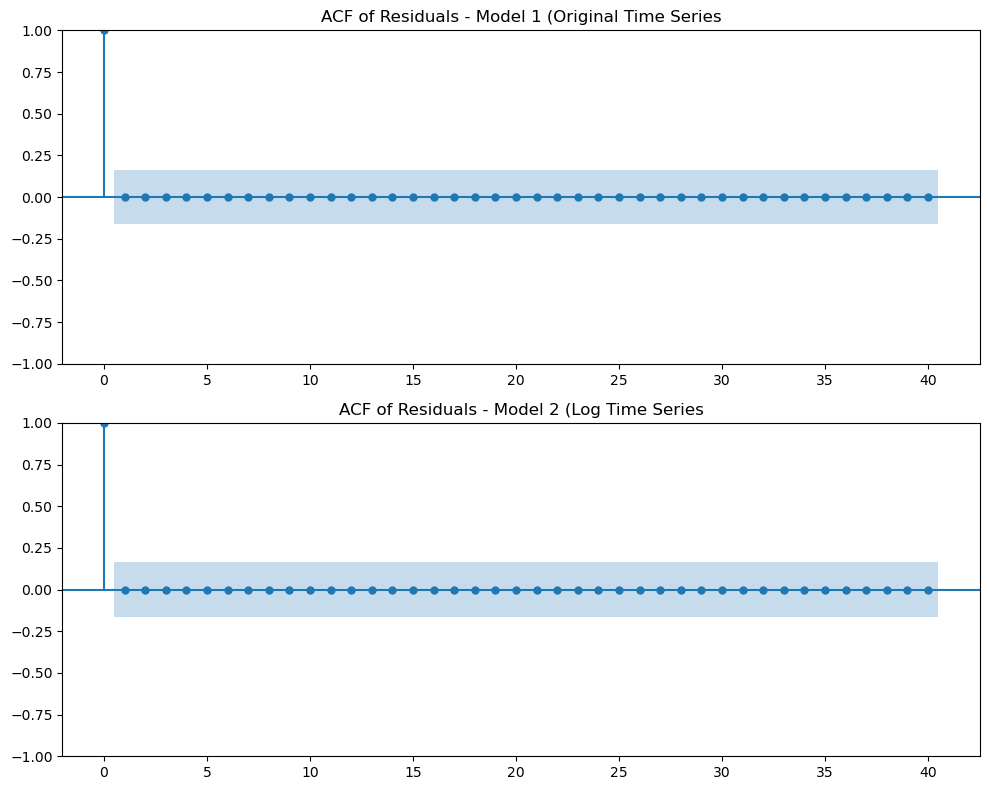

In [34]:
# Residuals Plot

import statsmodels.api as sm


residuals1 = arima1.resid()
residuals2 = arima2.resid()

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sm.graphics.tsa.plot_acf(residuals1, lags=40, ax=ax[0])
ax[0].set_title("ACF of Residuals - Model 1 (Original Time Series")

sm.graphics.tsa.plot_acf(residuals2, lags=40, ax=ax[1])
ax[1].set_title("ACF of Residuals - Model 2 (Log Time Series")

plt.tight_layout()
plt.show()

In [35]:
arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -705.955
Date:                Thu, 28 Aug 2025   AIC                           1413.909
Time:                        21:24:21   BIC                           1416.872
Sample:                    01-01-1949   HQIC                          1415.113
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1136.4014    119.157      9.537      0.000     902.858    1369.945
===================================================================================
Ljung-Box (L1) (Q):                  13.39   Jarque-Bera (JB):                 4.99
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               9.22   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 1, 1)   Log Likelihood                1287.245
Date:                Thu, 28 Aug 2025   AIC                          -2566.490
Time:                        21:24:22   BIC                          -2554.639
Sample:                             0   HQIC                         -2561.674
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0575   1.33e-19   7.98e+18      0.000       1.057       1.057
ar.L2         -0.4391   7.17e-19  -6.12e+17      0.000      -0.439      -0.439
ma.L1         -0.7080   3.89e-20  -1.82e+19      0.000      -0.708      -0.708
sigma2      7.158e-10   2.65e-10      2.705      0.007    1.97e-10    1.23e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.40   Prob(JB):                         0.73
Heteroskedasticity (H):               7.95   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.35e+35. Standard errors may be unstable.
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

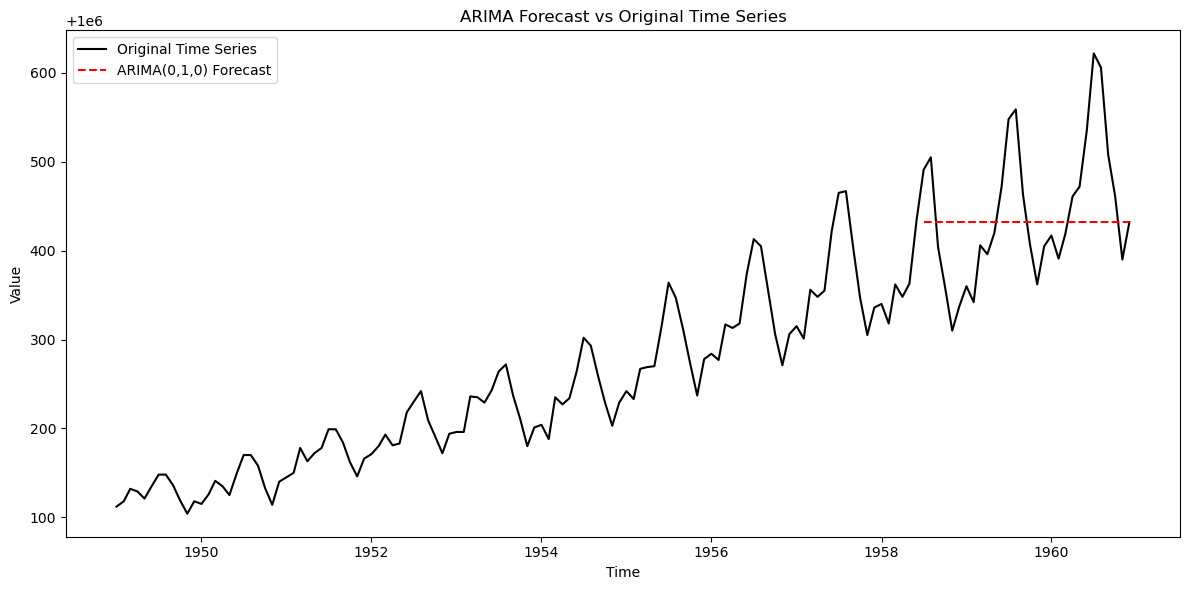

In [37]:
train_y, test_y = y[:-n_test], y[-n_test:]

plt.figure(figsize=(12, 6))
plt.plot(y, label="Original Time Series", color="black")
plt.plot(test_y.index, forecast_y, label="ARIMA(0,1,0) Forecast", color="red", linestyle="--")
plt.title("ARIMA Forecast vs Original Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

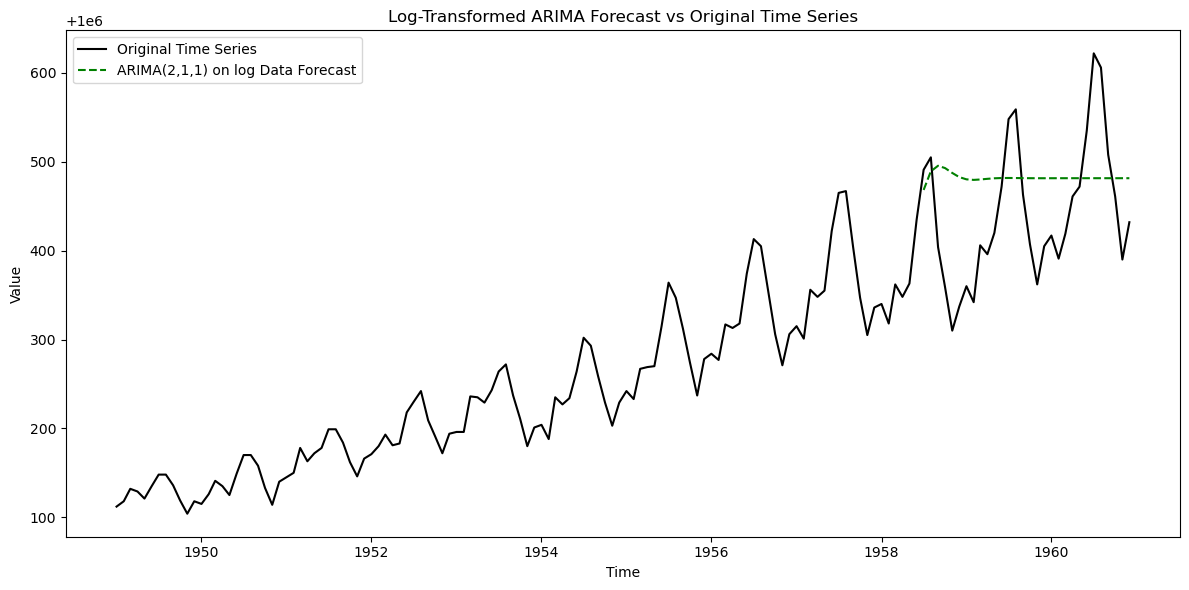

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(y, label="Original Time Series", color="black")
plt.plot(test_y.index, forecast_log_inv, label="ARIMA(2,1,1) on log Data Forecast", color="green", linestyle="--")
plt.title("Log-Transformed ARIMA Forecast vs Original Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
_ _ _ = _ _ _
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd._ _ _(date_range, columns = ['Month']
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd._ _ _(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]

# Plot your future predictions
# Call figure() on plt
plt._ _ _(figsize=(15,10))
plt.plot(y_log)
plt.plot(y_log['Nov 1960'].append(future_months['Prediction']))
plt.show()

In [ ]:
# Now plot the original variable y 
# Use the same functions as before
plt._ _ _(figsize=(15,10))
plt._ _ _(y)
plt._ _ _(np.exp(y_log['Nov 1960'].append(future_months['Prediction'])))
plt._ _ _()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

## Model Comparison and Forecast Evaluation

- **ARIMA(0,1,0)** shows a simpler trend but underfits the sharp fluctuations.
- **ARIMA(2,1,1) on log-transformed data** captures the dynamics better and yields a lower MSE.
- Based on the plots and residuals, the log-transformed ARIMA is preferable for forecasting.


## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 